In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import timm

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(224),   # Resize CIFAR-10 images from 32x32 → 224x224 (ResNet-50 input size)
    transforms.RandomHorizontalFlip(), # Augmentation: randomly flip images
    transforms.ToTensor(),    # Convert image to tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.Resize(224),   # Only resize + normalize (no augmentation for test)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


In [ ]:
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [ ]:
num_features = model.fc.in_features  # Get input features of the final fully connected layer
model.fc = nn.Linear(num_features, 10)  # Replace it with 10 outputs (CIFAR-10 classes)


In [ ]:
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:  # Unfreeze last block + final layer
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()   # Suitable for classification
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},  # lower LR for pretrained block
    {'params': model.fc.parameters(), 'lr': 1e-3}       # higher LR for new layer
])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
for epoch in range(10):  # Train for 10 epochs
    model.train()  # Training mode (enables dropout, BN updates)
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()      # Reset gradients
        outputs = model(images)    # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()            # Backprop
        optimizer.step()           # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


Epoch 1, Loss: 0.4001
Epoch 2, Loss: 0.2018
Epoch 3, Loss: 0.1300
Epoch 4, Loss: 0.0964
Epoch 5, Loss: 0.0738
Epoch 6, Loss: 0.0660
Epoch 7, Loss: 0.0576
Epoch 8, Loss: 0.0480
Epoch 9, Loss: 0.0401
Epoch 10, Loss: 0.0384


In [ ]:
model.eval()  # Evaluation mode (disable dropout, BN updates)
correct, total = 0, 0

with torch.no_grad():  # No gradients in inference
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # Get predicted class
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")


Test Accuracy: 92.30%


In [ ]:
torch.save(model.state_dict(), "resnet50_cifar10.pth")

In [ ]:
model_ViT = timm.create_model('vit_small_patch16_224', pretrained=True)

# Replace classifier head (ViT uses `head` instead of `fc`)
model_ViT.head = nn.Linear(model_ViT.head.in_features, 10)  # CIFAR-10 has 10 classes

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),
                         (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),
                         (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [ ]:
for param in model_ViT.parameters():
    param.requires_grad = False

# Unfreeze last transformer block
for param in model_ViT.blocks[-1].parameters():
    param.requires_grad = True

# Unfreeze classifier head
for param in model_ViT.head.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

# Fine-tune head + last block with different LRs
optimizer = torch.optim.AdamW([
    {'params': model_ViT.blocks[-1].parameters(), 'lr': 1e-4},
    {'params': model_ViT.head.parameters(), 'lr': 1e-3}
])

# Optional: cosine LR scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ViT = model_ViT.to(device)

for epoch in range(10):
    model_ViT.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_ViT(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Finished ✅")

Epoch 1, Loss: 0.1592
Epoch 2, Loss: 0.0750
Epoch 3, Loss: 0.0601
Epoch 4, Loss: 0.0502
Epoch 5, Loss: 0.0386
Epoch 6, Loss: 0.0282
Epoch 7, Loss: 0.0194
Epoch 8, Loss: 0.0156
Epoch 9, Loss: 0.0129
Epoch 10, Loss: 0.0102
Training Finished ✅


In [ ]:
model_ViT.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ViT(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 97.14%


In [ ]:
torch.save(model_ViT.state_dict(), "vit_s16_cifar10.pth")

In [ ]:

# Load the same ResNet-50 architecture
model = models.resnet50(pretrained=False)

# Adjust final layer again for CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Load the weights
model.load_state_dict(torch.load("resnet50_cifar10.pth"))

# Set model to evaluation mode
model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 1. Load the ViT-S/16 architecture (pretrained=False)
model_ViT = timm.create_model('vit_small_patch16_224', pretrained=False)

# 2. Replace classifier head for CIFAR-10
model_ViT.head = nn.Linear(model_ViT.head.in_features, 10)

# 3. Load the saved weights
model_ViT.load_state_dict(torch.load("vit_s16_cifar10.pth"))

# 4. Set model to evaluation mode
model_ViT.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:

def evaluate_model(model, dataloader, device):
    """
    Evaluate a model on a given dataset.

    Args:
        model: PyTorch model (ResNet, ViT, etc.)
        dataloader: DataLoader for the dataset
        device: 'cuda' or 'cpu'
    Returns:
        accuracy (float)
    """
    model.to(device)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total


In [ ]:
def compare_models(model_resnet, model_vit, dataloader, device):
    """
    Compare ResNet-50 and ViT models on the same dataset.

    Args:
        model_resnet: Fine-tuned ResNet-50 model
        model_vit: Fine-tuned ViT model
        dataloader: DataLoader (e.g., RGB test set, grayscale test set)
        device: 'cuda' or 'cpu'
    """
    acc_resnet = evaluate_model(model_resnet, dataloader, device)
    acc_vit = evaluate_model(model_vit, dataloader, device)

    print(f"ResNet-50 Accuracy: {acc_resnet:.2f}%")
    print(f"ViT Accuracy     : {acc_vit:.2f}%")

    return acc_resnet, acc_vit


In [ ]:
import random
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF

def grayscale_transform(img):
    return TF.to_grayscale(img, num_output_channels=3)

# (b) Translation
def translate_transform(img, max_shift=4):
    dx = random.randint(-max_shift, max_shift)
    dy = random.randint(-max_shift, max_shift)
    return TF.affine(img, angle=0, translate=(dx, dy), scale=1, shear=0)

# (c) Patch Occlusion
def occlusion_transform(img, patch_size=16):
    img = np.array(img).copy()
    h, w, c = img.shape
    x = random.randint(0, w - patch_size)
    y = random.randint(0, h - patch_size)
    img[y:y+patch_size, x:x+patch_size, :] = 128  # gray occlusion
    return Image.fromarray(img)

# (d) Patch Shuffle
def patch_shuffle_transform(img, patch_size=8):
    img = np.array(img)
    h, w, c = img.shape
    assert h % patch_size == 0 and w % patch_size == 0

    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patches.append(img[i:i+patch_size, j:j+patch_size, :])

    random.shuffle(patches)

    new_img = np.zeros_like(img)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            new_img[i:i+patch_size, j:j+patch_size, :] = patches[idx]
            idx += 1

    return Image.fromarray(new_img)

In [ ]:
from torchvision.datasets import CIFAR10
normalize = transforms.Normalize((0.5,0.5,0.5),
                                 (0.5,0.5,0.5))
def make_test_dataset(custom_transform):
    return CIFAR10(
        root="./data", train=False, download=True,
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.Lambda(custom_transform),
            transforms.ToTensor(),
            normalize
        ])
    )

In [ ]:
testsets = {
    "Grayscale": make_test_dataset(grayscale_transform),
    "Translation": make_test_dataset(translate_transform),
    "Occlusion": make_test_dataset(occlusion_transform),
    "PatchShuffle": make_test_dataset(patch_shuffle_transform)
}

testloaders = {name: torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False, num_workers=2)
               for name, ds in testsets.items()}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for name, testloader in testloaders.items():
  print("For ", name , "dataset:" )
  compare_models(model,model_ViT,testloader,device)

For  Grayscale dataset:
ResNet-50 Accuracy: 75.47%
ViT Accuracy     : 87.14%
For  Translation dataset:
ResNet-50 Accuracy: 90.95%
ViT Accuracy     : 96.98%
For  Occlusion dataset:
ResNet-50 Accuracy: 91.03%
ViT Accuracy     : 97.01%
For  PatchShuffle dataset:
ResNet-50 Accuracy: 10.07%
ViT Accuracy     : 14.63%


In [ ]:
def get_penultimate_features(model, dataloader, device, max_batches=5):
    model.eval()
    features, labels = [], []

    # Remove final classifier head
    if isinstance(model, torch.nn.DataParallel):
        base_model = model.module
    else:
        base_model = model

    if hasattr(base_model, "fc"):  # ResNet
        feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
    elif hasattr(base_model, "head"):  # ViT from timm
        feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
    else:
        raise ValueError("Model type not recognized for feature extraction")

    feature_extractor.to(device)

    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(dataloader):
            if i >= max_batches:  # limit for speed
                break
            imgs, lbls = imgs.to(device), lbls.to(device)
            feats = feature_extractor(imgs)
            feats = feats.view(feats.size(0), -1)  # flatten
            features.append(feats.cpu())
            labels.append(lbls.cpu())

    return torch.cat(features), torch.cat(labels)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_features(features, labels, method="pca", title="Feature Space"):
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
    else:
        raise ValueError("Use 'pca' or 'tsne'")

    reduced = reducer.fit_transform(features)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", alpha=0.6, s=10)
    plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.title(f"{title} ({method.upper()})")
    plt.show()

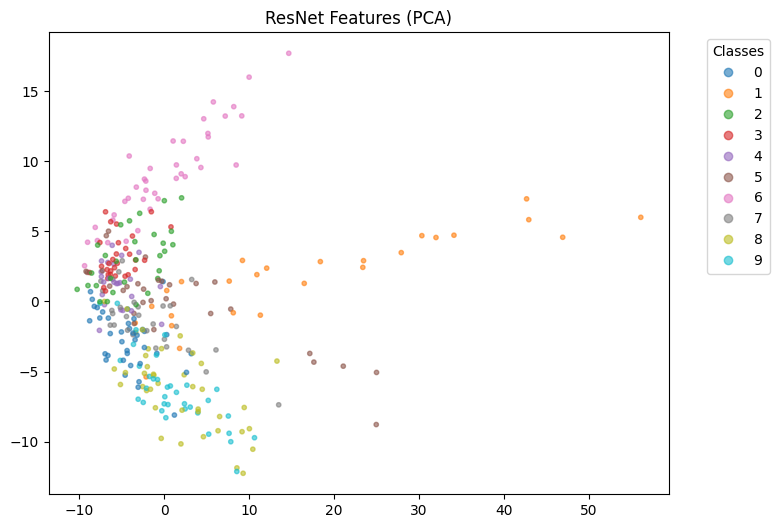

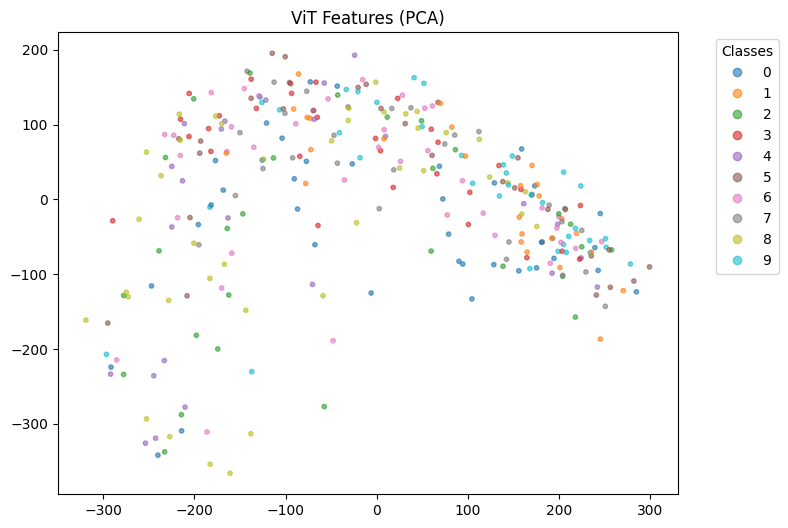

In [ ]:
resnet_feats, resnet_labels = get_penultimate_features(model, testloader, device)
vit_feats, vit_labels = get_penultimate_features(model_ViT, testloader, device)

plot_features(resnet_feats.numpy(), resnet_labels.numpy(), method="pca", title="ResNet Features")
plot_features(vit_feats.numpy(), vit_labels.numpy(), method="pca", title="ViT Features")


In [ ]:
! unzip dct2_images.zip -d dct2_images

Streaming output truncated to the last 5000 lines.
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0045.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0046.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0047.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0048.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0049.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0050.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0051.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0052.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0053.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0054.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0055.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0056.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dct_063_0059.jpg  
  inflating: dct2_images/dct2_images/photo/guitar/dc

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import os

# Data preprocessing
pacs_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Path to PACS dataset
data_dir = "/content/dct2_images/PACS"   # expects subfolders Photo/ Art/ Cartoon/ Sketch/

def get_pacs_loaders(data_dir, domains, batch_size=64):
    datasets_list = []
    for domain in domains:
        domain_path = os.path.join(data_dir, domain)
        ds = datasets.ImageFolder(domain_path, transform=pacs_transform)
        datasets_list.append(ds)
    combined = torch.utils.data.ConcatDataset(datasets_list)
    return DataLoader(combined, batch_size=batch_size, shuffle=True, num_workers=4)

# Train on Photo + Art + Cartoon
train_domains = ["photo", "art_painting", "cartoon"]
test_domain = "sketch"

train_loader = get_pacs_loaders(data_dir, train_domains)
test_loader = get_pacs_loaders(data_dir, [test_domain])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch.optim as optim
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet
resnet_model_PACS = timm.create_model("resnet50", pretrained=True, num_classes=7)  # PACS has 7 classes
resnet_model_PACS = resnet_model_PACS.to(device)

# ViT
vit_model_PACS = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=7)
vit_model_PACS = vit_model_PACS.to(device)

# Training setup (same for both)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model_PACS.parameters(), lr=1e-4)
optimizer_vit = optim.Adam(vit_model_PACS.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
def train_one_epoch(model, optimizer, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss/len(dataloader), correct/total

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct/total


In [ ]:
EPOCHS = 5  # increase for better performance

for epoch in range(EPOCHS):
    res_loss, res_acc = train_one_epoch(resnet_model_PACS, optimizer_resnet, train_loader)
    vit_loss, vit_acc = train_one_epoch(vit_model_PACS, optimizer_vit, train_loader)
    print(f"Epoch {epoch+1}: ResNet Acc={res_acc:.3f}, ViT Acc={vit_acc:.3f}")

# Final Evaluation on Sketch domain
resnet_acc = evaluate(resnet_model_PACS, test_loader)
vit_acc = evaluate(vit_model_PACS, test_loader)

print(f"ResNet-50 Sketch Accuracy: {resnet_acc:.3f}")
print(f"ViT-S/16 Sketch Accuracy: {vit_acc:.3f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: ResNet Acc=0.211, ViT Acc=0.260
Epoch 2: ResNet Acc=0.263, ViT Acc=0.396
Epoch 3: ResNet Acc=0.335, ViT Acc=0.526
Epoch 4: ResNet Acc=0.407, ViT Acc=0.644
Epoch 5: ResNet Acc=0.502, ViT Acc=0.788
ResNet-50 Sketch Accuracy: 0.230
ViT-S/16 Sketch Accuracy: 0.414


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/geirhos_conflict_stimuli/incomplete.UKBLQM_1.0.0/geirhos_conflict_stimuli-…

Dataset geirhos_conflict_stimuli downloaded and prepared to /root/tensorflow_datasets/geirhos_conflict_stimuli/1.0.0. Subsequent calls will reuse this data.


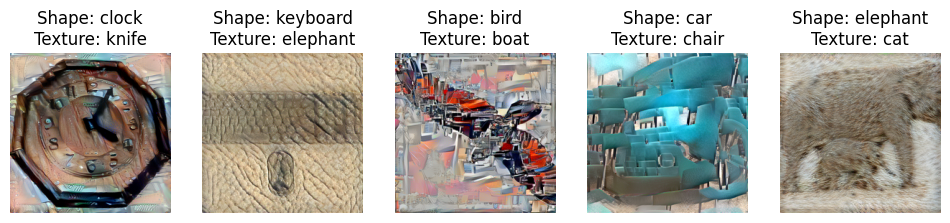

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load dataset
dataset, info = tfds.load('geirhos_conflict_stimuli', split='test', with_info=True)

# Get label names from info.features
shape_names = info.features['shape_label'].names
texture_names = info.features['texture_label'].names

# Visualize first 5 images with actual labels
plt.figure(figsize=(12,6))
for i, example in enumerate(dataset.take(5)):
    img = example['image']
    shape_label = shape_names[example['shape_label'].numpy()]   # map ID → name
    texture_label = texture_names[example['texture_label'].numpy()]

    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"Shape: {shape_label}\nTexture: {texture_label}")
    plt.axis('off')
plt.show()